In [1]:
# this notebook is for taking the annotations from the whale_edge_annotation interface
# and using that information to create a dataset of extracted patches (size 16x16) -> label map
# the label map is a 16x16x3 map of classes, the classes being (0 - bg, 1 - whale, 2 - trailing edge)
# the key thing that allows us to do this is the assumption that, in general, above the trailing edge
# is going to be background, and below is going to be whale, and the pixels that make the edge itself
# are accurately the trailing edge. While this may not always be true (e.g. the edge coming up on the side)
# it will be true often enough for the network to be robust to noise
# the goal of this is then to run the resulting network in a fully convolutional manner and get a (rough)
# segmentation of the whale, with its trailing edge clearly marked

In [2]:
from os.path import join
from glob import glob
import json
with open('../dataset_loc','r') as f:
    dataset_loc = f.read().rstrip()
annotation_path = "/home/andrew/whale_edge_annotations/annotation_info"
imgs_dir = join(dataset_loc,'Flukes/CRC_combined constrained/')
all_annotations = glob(join(annotation_path, '*'))
annotations_done = {}
for annotation_fn in all_annotations:
    with open(annotation_fn, 'r') as f:
        annotation = json.load(f)
        if annotation[1]['done']:
            annotations_done[annotation[0]] = annotation[1]['path']

In [3]:
# it looks like the path data is stored from end to start (no biggie) in x, y format
# so the idea is to set a patch size of 16 x 16 and at every 16 points (w/ a 50 point offset from the edges)
# we also want a good idea of what the background / whale looks like, so we should move some amount of pixels
# down with the assumption (potentially wrong, but hopefully right most of the time) that putting the # path
# (mostly) at the bottom (and sampling k patches above) gives us background, 
# and putting it (mostly) at the top gives us whale (fg) (and going down k times etc)
# the latter is more likely to be incorrect, especially towards the edges (just in general)
# to compensate for this we'll have k increase as we get towards the center of the path
# while there are definitely deformed tails that will violate a lot of this, we can safely assume
# that most of the tails annotated do not have this issue
def get_patch_coords(right_center, patch_size, img_shape):
    upper = right_center[0] - patch_size // 2
    lower = right_center[0] + patch_size // 2
    if upper < 0:
        upper = 0
        lower = patch_size
    if lower > img_shape[0]:
        lower = img_shape[0]
        upper = img_shape[0] - patch_size
    left = right_center[1] - patch_size
    right = right_center[1]
    if left < 0:
        left = 0
        right = patch_size
    if right > img_shape[1]:
        right = img_shape[1]
        left = img_shape[1] - patch_size
    return ((upper,left),(lower,right))

def extract_patches(path, img, edge_offset=50, patch_size=16, max_k=2):
    label_img = np.zeros((img.shape[0],img.shape[1],3))
    for coords in path:
        label_img[coords[1], coords[0], 0] = 1 # mark red the trailing edge
        label_img[(coords[1]+1):, coords[0], 1] = 1 # mark green below the trailing edge as whale (obv wrong)
        label_img[:coords[1], coords[0], 2] = 1 # mark blue above the trailing edge as background
    patches = []
    for sample_ind, patch_start in enumerate(path[edge_offset:-1*edge_offset:patch_size]):
        # extract the main patch with the center y at patch_start[y]
        right_col = patch_start[0]
        if right_col - patch_size < 0:
            continue
        center_row = patch_start[1]
        
        # move up patch_size // 2 max_k times (or until you hit the top of the image)
        above_rows = [center_row - (patch_size)*(k+1) for k in range(max_k)] # y decreases to go up
        
        # move down patch_size // 2 min(max_k - dist_from_center , 1) times
        distance_from_center = max(1,abs(sample_ind - (len(path[edge_offset:-1*edge_offset:patch_size])//2)))
        #print(distance_from_center)
        # ok so this is kinda fucked up but basically we want to go down a bit less towards the center
        # since (if we think about a perfect fluke image) the center is going to be closer to the water
        # we also want to go down less than we go up (hence max_k-1) to get more exposure of what 'bg'
        # looks like, and 
        below_rows = [center_row + (patch_size)*(k+1) for k in range(min(max_k, distance_from_center))] 
        for row in chain([center_row], above_rows, below_rows):
            if row < 0 or row >= img.shape[0]:
                continue
            vertices = get_patch_coords((row, right_col), patch_size, img.shape)
            # vertices is a set of coordinates marking the upper left and lower right (resp) corners
            # get_patch_coords guarantees that these coordinates are in bounds
            region = [slice(vertices[0][0], vertices[1][0]),
                      slice(vertices[0][1], vertices[1][1]),
                      slice(None)]
            patches.append((img[region], label_img[region], vertices))
    return patches

(32, 32, 3)


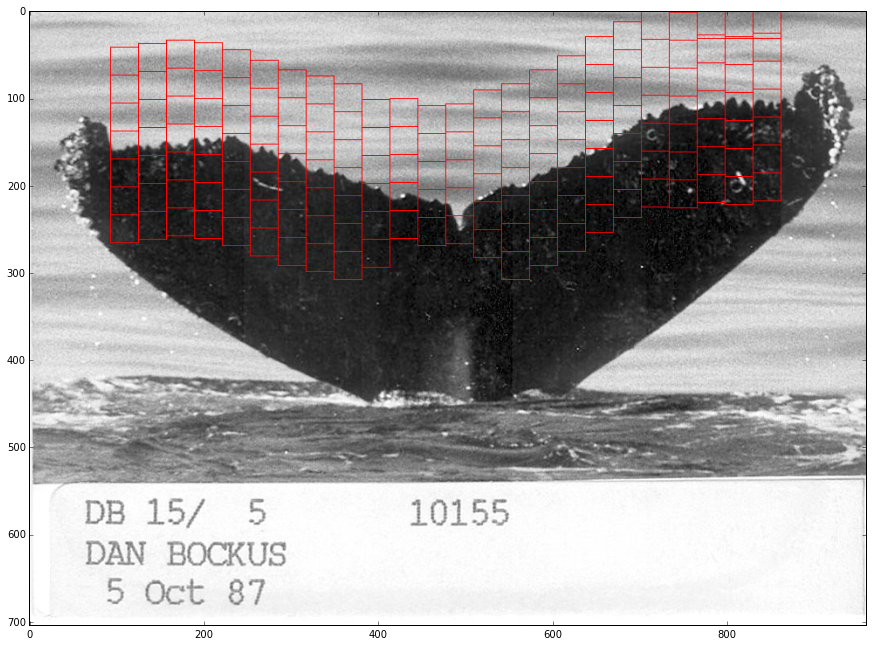

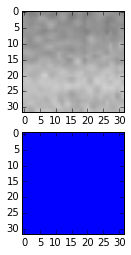

In [4]:
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
from itertools import chain
import copy
%matplotlib inline

def display_patch(patch):
    fig, axes = plt.subplots(2)
    axes[0].imshow(patch[0])
    axes[1].imshow(patch[1]) # blue: background, green: whale, red: edge
    print(patch[0].shape)
    
def display_sampled_patches(img, patches):
    display_img = copy.copy(img)
    for _, _, patch_vert in patches:
        cv2.rectangle(display_img, patch_vert[0][::-1], patch_vert[1][::-1], color=(255,0,0))
    plt.figure(figsize=(15,15))
    plt.imshow(display_img)
    
rand_imgfn = random.choice(annotations_done.keys())
rand_img = cv2.imread(join(imgs_dir, rand_imgfn))
img_patches = extract_patches(annotations_done[rand_imgfn], rand_img, max_k=3, patch_size=32, edge_offset=30)

display_sampled_patches(rand_img, img_patches)
display_patch(random.choice(img_patches))

In [5]:
all_patches = []
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
all_whole_imgs = annotations_done.keys()
imgs_shuffled = shuffle(all_whole_imgs)
train_imgs, test_imgs = train_test_split(imgs_shuffled)
train_imgs, val_imgs = train_test_split(train_imgs)

def get_patches(imgfns):
    all_patches = []
    for imgfn in imgfns:
        img = cv2.imread(join(imgs_dir, imgfn))
        img_patches = extract_patches(annotations_done[imgfn], img, max_k=3, patch_size=32, edge_offset=30)
        all_patches = chain(all_patches, img_patches)
    all_patches = list(all_patches)
    patch_imgs, patch_labels, _ = zip(*all_patches)
    return np.array(patch_imgs), np.array(patch_labels)

train_patches, train_labels = get_patches(train_imgs)
val_patches, val_labels = get_patches(val_imgs)
test_patches, test_labels = get_patches(test_imgs)

In [6]:
from train_utils import save_dataset

ERROR (theano.sandbox.cuda): Failed to compile cuda_ndarray.cu: libcublas.so.7.5: cannot open shared object file: No such file or directory
ERROR:theano.sandbox.cuda:Failed to compile cuda_ndarray.cu: libcublas.so.7.5: cannot open shared object file: No such file or directory
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu0 is not available  (error: cuda unavilable)


Couldn't import dot_parser, loading of dot files will not be possible.

+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______



In [7]:
train_patches.shape

(27271, 32, 32, 3)

In [8]:
save_dataset(join(dataset_loc,'Flukes/patches/annot_path_32'),
             (train_patches, train_labels),
             (val_patches, val_labels),
             (test_patches, test_labels))

Overwriting /home/zach/data/Flukes/patches/annot_path_32 y/n
y
Took 285.80 seconds


In [15]:
limit = 64
save_dataset(join(dataset_loc,'Flukes/patches/TESTannot_path_32'),
             (train_patches[:limit], train_labels[:limit]),
             (val_patches[:limit], val_labels[:limit]),
             (test_patches[:limit], test_labels[:limit]))

Took 1.02 seconds
